In [ ]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Set up the waypoints
waypoints = np.array([
    [0.0, 0.0],
    [0.5, 1.0],
    [1.0, 2.0],
    [1.5, 3.0],
    [2.0, 4.0]
])

# Fit a cubic spline to the waypoints
spline = CubicSpline(waypoints[:, 0], waypoints[:, 1])


# Define the polynomial coefficients
a0 = spline(waypoints[0, 0])
a1 = spline(waypoints[1, 0]) - a0
a2 = (spline(waypoints[2, 0]) - spline(waypoints[1, 0]) - a1) / (waypoints[2, 0] - waypoints[0, 0])**2
a3 = (spline(waypoints[3, 0]) - spline(waypoints[2, 0]) - a1 - 2*a2*(waypoints[3, 0] - waypoints[1, 0])) / (waypoints[3, 0] - waypoints[1, 0])**3

# Evaluate the polynomial at some points
x = np.linspace(0.0, 2.0, 100)
y = a0 + a1*(x - waypoints[0, 0]) + a2*(x - waypoints[0, 0])**2 + a3*(x - waypoints[0, 0])**3


plt.plot(x,y)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sampled time points
t = np.linspace(0, 5, 101)

# Coefficients of the polynomial
a0, a1, a2 = 0, 1, 0

# Evaluate the polynomial at each time point
x = a0 + a1*t + a2*t**2

# Plot the trajectory
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.show()

## Path Planning and trajectry generation
#  **Goal of the Project**
1. Create a path through way points
2. Linear interpolation through the waypoints
3. cubicspile for interpolation, creating a smooth curve
4. make a diff drive robot follow this path at given speed and accelaration, constanlty print-> Position, velcoty, accelration
5. create a velocity profile and accelartion profile
6. Impliment s curve profile(at the beginning and end of the trapezoidal curve)
7. create a simulation


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline



In [ ]:
## Creating a 10 random way points
num_waypoints = 10
# Specify the x and y coordinates of the waypoints
waypoints_x = np.array([0, 2, 5, 7, 10])
waypoints_y = np.array([0, 3, 6, 5, 8])

# Combine the x and y coordinates into a single array
waypoints = np.column_stack((waypoints_x, waypoints_y))
waypoints

In [ ]:
interp_points = 100
x = np.linspace(waypoints[0,0], waypoints[-1,0], interp_points)
y = np.interp(x, waypoints[:,0], waypoints[:,1])


'''This piece of code performs linear interpolation between the x-coordinates of the waypoints and the y-coordinates of the waypoints.

np.linspace(waypoints[0,0], waypoints[-1,0], interp_points) generates interp_points evenly spaced points between the first and last x-coordinates of the waypoints.

np.interp(x, waypoints[:,0], waypoints[:,1]) performs linear interpolation between the x-coordinates of the waypoints and the y-coordinates of the waypoints at the x-coordinates generated by np.linspace().

The resulting x and y arrays can be used to plot the interpolated path.'''

In [ ]:
plt.plot(waypoints[:,0], waypoints[:,1], 'ro', label='Waypoints')
plt.plot(x, y, 'b-', label='Interpolated Path')
plt.legend()
plt.show()

There are several strategies to smooth out a path, some of them are:

B-spline interpolation: B-splines are a popular method for smoothing out paths. They are mathematical functions that can be used to approximate a given set of points. B-splines are easy to compute and can be used to generate a smooth curve through a set of waypoints.

Bezier curves: Bezier curves are another popular method for smoothing out paths. They are similar to B-splines but use control points to define the curve. Bezier curves are easy to compute and can be used to generate smooth curves through a set of waypoints.

Smoothing algorithms: There are several algorithms that can be used to smooth out paths. Some of the popular ones include the Douglas-Peucker algorithm, the Ramer-Douglas-Peucker algorithm, and the Kalman filter.

Optimization-based methods: Optimization-based methods can be used to generate smooth paths that minimize some objective function. For example, one can minimize the total curvature of the path or minimize the deviation from a straight line.

All of these strategies can be implemented in Python using various libraries such as NumPy, SciPy, and Matplotlib.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



# Compute the cubic spline curve
spline = CubicSpline(waypoints[:, 0], waypoints[:, 1])

# Define the range of the curve
x_range = np.linspace(waypoints[0, 0], waypoints[-1, 0], 100)

# Evaluate the curve at the range values
y_range = spline(x_range)

# Plot the original waypoints and the smoothed curve
plt.plot(waypoints[:, 0], waypoints[:, 1], 'o', label='Waypoints')
plt.plot(x_range, y_range, label='Cubic Spline')
plt.plot(waypoints[:,0], waypoints[:,1], 'ro', label='Waypoints')
plt.plot(x, y, 'b-', label='Interpolated Path')
plt.legend()
plt.show()

In [ ]:
# Define the robot's maximum velocity and acceleration
v_max = 2.0 # m/s
v_min = 0.5 # m/s
a_max = 1 # m/s^2
a_min = -1 # m/s^2

# Compute the velocity and acceleration profiles for the robot to follow the path
dx = np.diff(x_range)
dy = np.diff(y_range)
ds = np.sqrt(dx**2 + dy**2)
s_total = np.cumsum(ds)

In [ ]:
v_profile = np.zeros_like(s_total)
a_profile = np.zeros_like(s_total)


In [ ]:
for i in range(1, len(s_total)-1):
    # Compute the desired velocity based on the distance to the next waypoint
    dist = s_total[-1] - s_total[i]
    #if the distance to be travelled is less than the distance required to stop v = v_min
    v_des = v_min if dist < (v_min**2)/(2*a_max) else np.sqrt(2*a_max*dist)
    v_des = min(v_des, v_max)
    
    # Compute the maximum allowed acceleration based on the robot's current velocity
    v_prev = v_profile[i-1] if i > 1 else 0
    a_max_allowed = a_max if v_des >= v_prev else a_min
    
    # Compute the actual acceleration based on the desired and allowed accelerations
    a_actual = min(a_max_allowed, max(a_min, (v_des**2 - v_prev**2)/(2*(s_total[i] - s_total[i-1]))))
    a_profile[i] = a_actual
    
    # Compute the actual velocity based on the desired and actual accelerations
    v_actual = np.sqrt(v_prev**2 + 2*a_actual*(s_total[i] - s_total[i-1]))
    v_profile[i] = min(v_des, v_actual)

In [ ]:
t = [i for i in range(len(v_profile))]
plt.plot(t, v_profile)
plt.xlabel("time")
plt.ylabel("velocity")

In [ ]:
s_total

In [ ]:
plt.plot(s_total, v_profile)
plt.plot()

In [ ]:
len(s_total), len(v_profile)

In [ ]:
from scipy.interpolate import  CubicSpline, UnivariateSpline
x = np.array([0,2, 4, 6, 8,10, 12])
y = np.array([0,2, 4, 4, 4, 2,0])
spline = UnivariateSpline(x, y)
x_new = np.linspace(x[0], x[-1], 50)
y_new = spline(x_new)
plt.plot(x_new, y_new)
plt.plot(x, y)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the profile parameters
v_max = 0.5  # maximum velocity (m/s)
a_max = 0.25  # maximum acceleration (m/s^2)
d_total = 10  # total distance to travel (m)

# Compute the trapezoidal velocity profile
t_accel = v_max / a_max  # time to reach maximum velocity
d_accel = 0.5 * a_max * t_accel**2  # distance traveled during acceleration
t_const = (d_total - 2*d_accel) / v_max  # time spent at maximum velocity
t_decel = t_accel  # time to decelerate
d_decel = d_accel  # distance traveled during deceleration

# Compute the time and position arrays
t = np.linspace(0, t_accel + t_const + t_decel, num=1000)
v = np.zeros_like(t)
d = np.zeros_like(t)

for i, time in enumerate(t):
    if time < t_accel:
        v[i] = a_max * time
        d[i] = 0.5 * a_max * time**2
    elif time < t_accel + t_const:
        v[i] = v_max
        d[i] = d_accel + v_max * (time - t_accel)
    else:
        t_rel = time - t_accel - t_const
        v[i] = v_max - a_max * t_rel
        d[i] = d_total - 0.5 * a_max * t_rel**2 - d_decel

# Plot the velocity profile
plt.plot(d, v)
plt.xlabel('Position (m)')
plt.ylabel('Velocity (m/s)')
plt.title('Trapezoidal Velocity Profile')
plt.show()


In [ ]:

plt.figure(figsize=(10,6))
plt.subplot(311)
plt.plot(s_total, x_range[:-1], label='x')
plt.plot(s_total, y_range[:-1], label='y')
plt.xlabel('Distance along path (m)')
plt.ylabel('Position (m)')
plt.legend()

plt.subplot(312)
plt.plot(s_total[:-1], v_profile[:-1])
plt.xlabel


In [ ]:
v_profile

In [ ]:
s_total[:]

In [ ]:
v_max = 4
a_max = 2
V_min = 0.5
D = 10

In [ ]:
#time take to reach the max velocity
t1 = v_max/a_max
#distance travelled to reach max velocity
d1 = v_max**2/(2*a_max)
t3 = t1
d3 = d1
d2 = D-2*d1
t2 = d2/v_max


In [ ]:
t1,t2,t3


In [ ]:
d1, d2, d3

In [ ]:
T1 = np.linspace(0,t1,50)
D1 = np.linspace(0,d1,50)

T2 = np.linspace(t1, t1+t2,50)
D2 = np.linspace(d1, d1+d2,50)

T3 = np.linspace(t1+t2, t1+t2+t1,50)
D3 = np.linspace(d1+d2, d1+d2+d3,50)



In [ ]:
args = (T1,T2,T3)
Dargs = (D1, D2, D3)
T = np.concatenate(args)
D = np.concatenate(Dargs)

In [ ]:
plt.plot(T,D)

In [ ]:
v = np.divide(D, T)

In [ ]:
plt.plot(T, v)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline


In [ ]:
waypoints = np.array([
    [0.0, 0.0],
    [1, 2.0],
    [5.0, 3.0],
    [6, 5.0],
    [8.0, 8.0]
])
spline = CubicSpline(waypoints[:, 0], waypoints[:, 1])

# Define the range of the curve
x_range = np.linspace(waypoints[0, 0], waypoints[-1, 0], 100)

# Evaluate the curve at the range values
y_range = spline(x_range)

# Plot the original waypoints and the smoothed curve
plt.plot(waypoints[:, 0], waypoints[:, 1], 'o', label='Waypoints')
plt.plot(x_range, y_range, label='Cubic Spline')

plt.legend()
plt.show()

In [ ]:
dx = np.diff(x_range)
dy = np.diff(y_range)
ds = np.sqrt(dx**2 + dy**2)
s_total = np.cumsum(ds)
v_max = 2
a_max = 4
t_total = v_max/s_total[-1] 

 

In [ ]:
derivative  = spline.derivative()

In [ ]:
x =  np.linspace(waypoints[0, 0], waypoints[-1, 0], 100)
y = derivative(x)

In [ ]:
angle = np.arctan([i for i in y])

In [ ]:
plt.plot(x_range, y_range, label='Cubic Spline')
plt.plot(x_range, angle, label='Cubic Spline')

In [ ]:
plt.plot(waypoints[:, 0], waypoints[:, 1], 'o', label='Waypoints')
plt.plot(x_range, y_range, label='Cubic Spline')
plt.plot(x, y, label='derivative')
plt.legend()
plt.show()

In [ ]:
import roboticstoolbox
q0 = s_total[0]
qf = s_total[-1]
v_max = 2
a_max = 1
d1 = v_max**2/2*a_max
d3 = d1
d2 = s_total[-1]-d3-d1
t1 = v_max/a_max
t3 = t1
t2 = v_max/d2
t_total = t1+t2+t3
t1,t2,t3, d1, d2, d3, s_total[-1], t_total
profile = roboticstoolbox.tools.trajectory.trapezoidal(q0, qf, t_total, V=v_max)

In [ ]:
profile.plot()

In [ ]:
v = profile.qd
v

In [ ]:
t = profile.t
t


In [ ]:
d = profile.q
d

In [ ]:
a = profile.qdd
a

In [ ]:
plt.plot(t, d)
plt.plot(t, v)

In [ ]:
plt.plot(v, d)

In [ ]:
"""

Path tracking simulation with pure pursuit steering and PID speed control.

author: Atsushi Sakai (@Atsushi_twi)
        Guillaume Jacquenot (@Gjacquenot)

"""
import numpy as np
import math
import matplotlib.pyplot as plt

# Parameters
k = 0.1  # look forward gain
Lfc = 2.0  # [m] look-ahead distance
Kp = 1.0  # speed proportional gain
dt = 0.1  # [s] time tick
WB = 2.9  # [m] wheel base of vehicle

show_animation = True


class State:

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v
        self.rear_x = self.x - ((WB / 2) * math.cos(self.yaw))
        self.rear_y = self.y - ((WB / 2) * math.sin(self.yaw))

    def update(self, a, delta):
        self.x += self.v * math.cos(self.yaw) * dt
        self.y += self.v * math.sin(self.yaw) * dt
        self.yaw += self.v / WB * math.tan(delta) * dt
        self.v += a * dt
        self.rear_x = self.x - ((WB / 2) * math.cos(self.yaw))
        self.rear_y = self.y - ((WB / 2) * math.sin(self.yaw))

    def calc_distance(self, point_x, point_y):
        dx = self.rear_x - point_x
        dy = self.rear_y - point_y
        return math.hypot(dx, dy)


class States:

    def __init__(self):
        self.x = []
        self.y = []
        self.yaw = []
        self.v = []
        self.t = []

    def append(self, t, state):
        self.x.append(state.x)
        self.y.append(state.y)
        self.yaw.append(state.yaw)
        self.v.append(state.v)
        self.t.append(t)


def proportional_control(target, current):
    a = Kp * (target - current)

    return a


class TargetCourse:

    def __init__(self, cx, cy):
        self.cx = cx
        self.cy = cy
        self.old_nearest_point_index = None

    def search_target_index(self, state):

        # To speed up nearest point search, doing it at only first time.
        if self.old_nearest_point_index is None:
            # search nearest point index
            dx = [state.rear_x - icx for icx in self.cx]
            dy = [state.rear_y - icy for icy in self.cy]
            d = np.hypot(dx, dy)
            ind = np.argmin(d)
            self.old_nearest_point_index = ind
        else:
            ind = self.old_nearest_point_index
            distance_this_index = state.calc_distance(self.cx[ind],
                                                      self.cy[ind])
            while True:
                distance_next_index = state.calc_distance(self.cx[ind + 1],
                                                          self.cy[ind + 1])
                if distance_this_index < distance_next_index:
                    break
                ind = ind + 1 if (ind + 1) < len(self.cx) else ind
                distance_this_index = distance_next_index
            self.old_nearest_point_index = ind

        Lf = k * state.v + Lfc  # update look ahead distance

        # search look ahead target point index
        while Lf > state.calc_distance(self.cx[ind], self.cy[ind]):
            if (ind + 1) >= len(self.cx):
                break  # not exceed goal
            ind += 1

        return ind, Lf


def pure_pursuit_steer_control(state, trajectory, pind):
    ind, Lf = trajectory.search_target_index(state)

    if pind >= ind:
        ind = pind

    if ind < len(trajectory.cx):
        tx = trajectory.cx[ind]
        ty = trajectory.cy[ind]
    else:  # toward goal
        tx = trajectory.cx[-1]
        ty = trajectory.cy[-1]
        ind = len(trajectory.cx) - 1

    alpha = math.atan2(ty - state.rear_y, tx - state.rear_x) - state.yaw

    delta = math.atan2(2.0 * WB * math.sin(alpha) / Lf, 1.0)

    return delta, ind


def plot_arrow(x, y, yaw, length=1.0, width=0.5, fc="r", ec="k"):
    """
    Plot arrow
    """

    if not isinstance(x, float):
        for ix, iy, iyaw in zip(x, y, yaw):
            plot_arrow(ix, iy, iyaw)
    else:
        plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw),
                  fc=fc, ec=ec, head_width=width, head_length=width)
        plt.plot(x, y)


def main():
    #  target course
    cx = np.arange(0, 50, 0.5)
    cy = [math.sin(ix / 5.0) * ix / 2.0 for ix in cx]

    target_speed = 10.0 / 3.6  # [m/s]

    T = 100.0  # max simulation time

    # initial state
    state = State(x=-0.0, y=-3.0, yaw=0.0, v=0.0)

    lastIndex = len(cx) - 1
    time = 0.0
    states = States()
    states.append(time, state)
    target_course = TargetCourse(cx, cy)
    target_ind, _ = target_course.search_target_index(state)

    while T >= time and lastIndex > target_ind:

        # Calc control input
        ai = proportional_control(target_speed, state.v)
        di, target_ind = pure_pursuit_steer_control(
            state, target_course, target_ind)

        state.update(ai, di)  # Control vehicle

        time += dt
        states.append(time, state)

        if show_animation:  # pragma: no cover
            plt.cla()
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect(
                'key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])
            plot_arrow(state.x, state.y, state.yaw)
            plt.plot(cx, cy, "-r", label="course")
            plt.plot(states.x, states.y, "-b", label="trajectory")
            plt.plot(cx[target_ind], cy[target_ind], "xg", label="target")
            plt.axis("equal")
            plt.grid(True)
            plt.title("Speed[km/h]:" + str(state.v * 3.6)[:4])
            plt.pause(0.001)

    # Test
    assert lastIndex >= target_ind, "Cannot goal"

    if show_animation:  # pragma: no cover
        plt.cla()
        plt.plot(cx, cy, ".r", label="course")
        plt.plot(states.x, states.y, "-b", label="trajectory")
        plt.legend()
        plt.xlabel("x[m]")
        plt.ylabel("y[m]")
        plt.axis("equal")
        plt.grid(True)

        plt.subplots(1)
        plt.plot(states.t, [iv * 3.6 for iv in states.v], "-r")
        plt.xlabel("Time[s]")
        plt.ylabel("Speed[km/h]")
        plt.grid(True)
        plt.show()


if __name__ == '__main__':
    print("Pure pursuit path tracking simulation start")
    main()

In [ ]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Define the trajectory as a cubic spline
waypoints_x = np.array([0, 2, 5, 7, 10])
waypoints_y = np.array([0, 3, 6, 5, 8])

# Combine the x and y coordinates into a single array
waypoints = np.column_stack((waypoints_x, waypoints_y))
waypoints
spline = CubicSpline(waypoints[:, 0], waypoints[:, 1])

# Define the range of the curve
x_range = np.linspace(waypoints[0, 0], waypoints[-1, 0], 100)

# Evaluate the curve at the range values
y_range = spline(x_range)


# Define the velocity profile
v_max = 1.0
a_max = 0.5
v_profile = np.minimum(v_max, a_max * t)

# Define the wheelbase and maximum wheel velocity
L = 0.5
w_max = 2.0

# Sample the trajectory at a fixed rate
dt = 0.1
t_sample = np.arange(0, t[-1], dt)
x_sample = spline(t_sample)
dx_sample = spline(t_sample, 1)
ddx_sample = spline(t_sample, 2)

# Calculate the desired linear and angular velocities at each point on the curve
v_sample = np.interp(t_sample, t, v_profile)
w_sample = np.cross(np.vstack([dx_sample, np.zeros_like(dx_sample)]).T, np.vstack([ddx_sample, np.zeros_like(ddx_sample)]).T)[:, 2] * v_sample

# Convert the desired linear and angular velocities to left and right wheel velocities
vl_sample = (v_sample - L/2*w_sample) / (w_max/2)
vr_sample = (v_sample + L/2*w_sample) / (w_max/2)

# Define the robot state
x_robot = np.zeros(2)
theta_robot = 0.0

# Define the robot size for plotting
robot_size = 0.2

# Define the plot
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Robot Trajectory')
ax.plot(x, y, 'k--', label='Cubic Spline')
ax.plot(x_robot[0], x_robot[1], 'ro', label='Robot')
ax.legend()

# Define the animation function
def animate(i):
    global x_robot, theta_robot
    # Move the robot according to the desired wheel velocities
    dtheta = (vr_sample[i] - vl_sample[i]) / L
    dx = w_max / 2 * (vl_sample[i] + vr_sample[i]) * np.cos(theta_robot)
    dy = w_max / 2 * (vl_sample[i] + vr_sample[i]) * np.sin(theta_robot)
    x_robot += np.array([dx, dy])
    theta_robot += dtheta
    # Update the plot
    ax.lines[-1].set_xdata(np.append(ax.lines[-1].get_xdata(), x_robot[0]))
    ax.lines[-1].set_ydata(np.append(ax.lines[-1].get_ydata(), x_robot[1]))
    ax.lines[-1].set_label('Robot (t={:.1f})'.format(t_sample[i]))
    ax.legend()
    ax.add_patch(plt.Circle(x_robot, robot_size/2, color='r'))
    return ax.lines[-1], ax.patches[-1]

# Run the animation
ani = animation.FuncAnimation(fig, animate, frames=len(t_sample), interval=100)
plt.show()


In [1]:
from roboticstoolbox.tools import trajectory
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
waypoints_x = np.array([0, 2, 5, 7, 10])
waypoints_y = np.array([0, 3, 6, 5, 8])
timestep = 0.1 #sec

# Combine the x and y coordinates into a single array
waypoints = np.column_stack((waypoints_x, waypoints_y))
waypoints
spline = CubicSpline(waypoints[:, 0], waypoints[:, 1])

# Define the range of the curve
x_range = np.arange(waypoints[0, 0], waypoints[-1, 0], timestep)

# Evaluate the curve at the range values
y_range = spline(x_range)

In [3]:
x_diff = np.diff(x_range)
y_diff = np.diff(y_range)
dist = np.sqrt(x_range**2+y_range**2)
cumdist = np.cumsum(dist)
cumdist.shape, cumdist[-1]

((100,), 677.3714640509737)

In [37]:
start = cumdist[0]
end = cumdist[-1]
total_distance = cumdist[-1]
v_max = 2
total_time = int(total_distance//v_max)
total_time
v_max = (total_distance//total_time)*1.5
t = np.arange(0,total_time,0.1)
start, end, total_time, v_max


(0.0, 677.3714640509737, 338, 3.0)

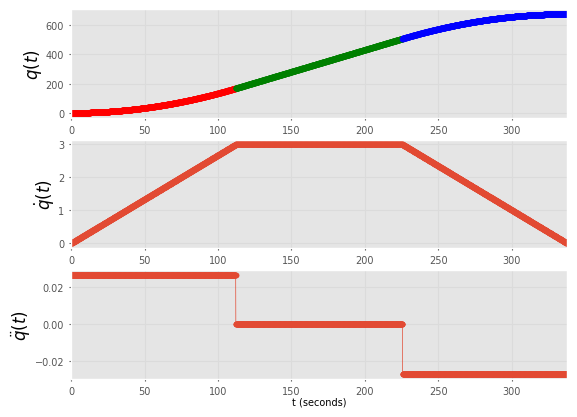

In [38]:
trapezoidal_profile = trajectory.trapezoidal(start, end, t, V=v_max)
trapezoidal_profile.plot()

In [44]:
v = trapezoidal_profile.qd
len(v)

3380

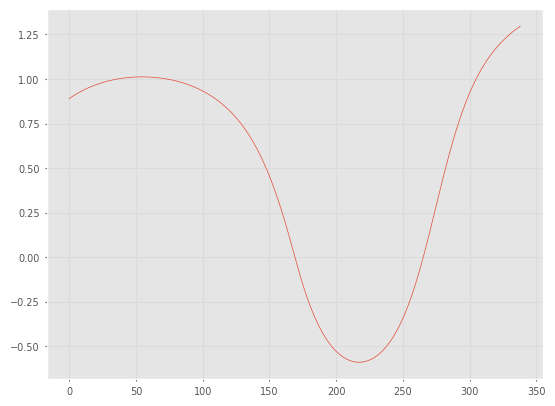

In [67]:
x_range = np.linspace(waypoints[0, 0], waypoints[-1, 0], len(v))
y_range = spline(x_range)
x_range.shape, y_range.shape
x_diff = np.diff(x_range)
y_diff = np.diff(y_range)
dist = np.sqrt(x_range**2+y_range**2)
cumdist = np.cumsum(dist)
theta = np.arctan2(y_diff,x_diff)
theta = np.concatenate(([theta[0]], theta))
plt.plot(t, theta)

In [68]:
v = trapezoidal_profile.qdd
v.shape

(3380,)

In [72]:
#angular velocity
dt = 0.1
dtheta = np.diff(theta)
dtheta = np.concatenate(([dtheta[0]], dtheta))
w = dtheta/dt
w.shape

(3380,)

In [73]:
l = 1
r = 0.5

v_l = (v - (l/2)*w) / r

v_r = (v + (l/2)*w) / r


In [2]:
import pygame
import numpy as np

# Initialize Pygame
pygame.init()

# Set the dimensions of the screen
screen_width = 800
screen_height = 600
screen = pygame.display.set_mode((screen_width, screen_height))

# Set up the robot
robot_width = 50
robot_height = 50
robot_x = screen_width / 2
robot_y = screen_height / 2
robot_angle = 0

# Set up the velocities
linear_velocity = 0.1  # in pixels per millisecond
angular_velocity = 0.01  # in radians per millisecond

# Set up the clock
clock = pygame.time.Clock()

# Run the control loop
while True:
    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
            sys.exit()

    # Update the robot position and angle based on the velocities
    robot_x += linear_velocity * np.cos(robot_angle)
    robot_y += linear_velocity * np.sin(robot_angle)
    robot_angle += angular_velocity

    # Draw the robot
    pygame.draw.rect(screen, (255, 0, 0), (robot_x - robot_width / 2, robot_y - robot_height / 2, robot_width, robot_height))
    pygame.draw.line(screen, (255, 255, 0), (robot_x, robot_y), (robot_x + 50 * np.cos(robot_angle), robot_y + 50 * np.sin(robot_angle)))

    # Update the display
    pygame.display.update()

    # Limit the frame rate
    clock.tick(60)


KeyboardInterrupt: 